In [1]:
import sys
import argparse
import collections.abc
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import traceback
from pathlib import Path
import pandas as pd

In [2]:
ps aux | grep ray::IDLE | grep -v grep | awk '{print $2}' | xargs kill -9
ps aux | grep ray | grep -v grep | awk '{print $2}' | xargs kill -9

SyntaxError: invalid syntax (<ipython-input-2-5202ba678888>, line 1)

In [3]:

import torch
torch.__version__

'1.7.1'

In [4]:
#import pandas as pd
pd.__version__

'1.3.3'

In [5]:
import random

In [6]:
random.seed(0)

def plot_agent(ax, df, color, step_aggregation='sum', linestyle='-',label='label'):
    num = random.randint(1,10)
    world_shape = df.attrs['env_config']['world_shape']
    max_cov = world_shape[0]*world_shape[1]*df.attrs['env_config']['min_coverable_area_fraction']
    d = (df.sort_values(['trial', 'step']).groupby(['trial', 'step'])['reward'].apply(step_aggregation, 'step').groupby('trial').cumsum()/max_cov*100).groupby('step')
    ax.plot(d.mean(), color=color, ls=linestyle,label=label,markevery=(int(50/(num+1))*num,50))
    ax.fill_between(np.arange(len(d.mean())), np.clip(d.mean()-d.std(), 0, None), d.mean()+d.std(), alpha=0.1, color=color)

def plot(data,out_file):
    fig_overview = plt.figure(figsize=[4, 4])
    ax = fig_overview.subplots(1, 1)

    df = pd.read_pickle(data)
    if Path(data).name.startswith('eval_adv'):
        plot_agent(ax, df[(df['comm'] == False) & (df['agent'] == 0)], 'r', step_aggregation='mean', linestyle=':',label="nocomm_adv")
        plot_agent(ax, df[(df['comm'] == False) & (df['agent'] > 0)], 'b', step_aggregation='mean', linestyle=':',label="nocomm_coop")
        plot_agent(ax, df[(df['comm'] == True) & (df['agent'] == 0)], 'r', step_aggregation='mean', linestyle='-',label="comm_adv")
        plot_agent(ax, df[(df['comm'] == True) & (df['agent'] > 0)], 'b', step_aggregation='mean', linestyle='-',label="comm_coop")
    elif Path(args.data).name.startswith('eval_coop'):
        plot_agent(ax, df[(df['comm'] == False) & (df['agent'] > 0)], 'b', step_aggregation='sum', linestyle=':',label="nocomm_coop")
        plot_agent(ax, df[(df['comm'] == True) & (df['agent'] > 0)], 'b', step_aggregation='sum', linestyle='-',label="comm_coop")
    elif Path(args.data).name.startswith('eval_rand'):
        plot_agent(ax, df[df['agent'] > 0], 'b', step_aggregation='sum', linestyle='-')

    ax.set_ylabel("Coverage %")
    ax.set_ylim(0, 100)
    ax.set_xlabel("Episode time steps")
    ax.margins(x=0, y=0)
    ax.grid()
    
    plt.legend()

    fig_overview.tight_layout()
    if out_file is not None:
        fig_overview.savefig(out_file, dpi=300)

    plt.show()

In [7]:
random.seed(0)
def plot_agent2(ax, df, color, step_aggregation='sum', linestyle='-',label='label',marker="x",me=50):
    world_shape = df.attrs['env_config']['world_shape']
    max_cov = world_shape[0]*world_shape[1]*df.attrs['env_config']['min_coverable_area_fraction']
    d = (df.sort_values(['trial', 'step']).groupby(['trial', 'step'])['reward'].apply(step_aggregation, 'step').groupby('trial').cumsum()/max_cov*100).groupby('step')
    ax.plot(d.mean(), color=color, ls=linestyle,label=label,linewidth=3,markevery=me,marker=marker,markersize=10)
    ax.fill_between(np.arange(len(d.mean())), np.clip(d.mean()-d.std(), 0, None), d.mean()+d.std(), alpha=0.1, color=color)

def plot2(data,out_file):
    fig_overview = plt.figure(figsize=[4, 4])
    ax = fig_overview.subplots(1, 1)

    df = pd.read_pickle(data)
    if Path(data).name.startswith('eval_adv'):
        plot_agent2(ax, df[(df['comm'] == False) & (df['agent'] == 0)], 'r', step_aggregation='mean', linestyle=':',label="nocomm adv")
        plot_agent2(ax, df[(df['comm'] == False) & (df['agent'] > 0)], 'b', step_aggregation='mean', linestyle=':',label="nocomm coop")
        #plot_agent(ax, df[(df['comm'] == True) & (df['agent'] == 0)], 'r', step_aggregation='mean', linestyle='-',label="comm_adv")
        #plot_agent(ax, df[(df['comm'] == True) & (df['agent'] > 0)], 'b', step_aggregation='mean', linestyle='-',label="comm_coop")
    elif Path(args.data).name.startswith('eval_coop'):
        plot_agent2(ax, df[(df['comm'] == False) & (df['agent'] > 0)], 'b', step_aggregation='sum', linestyle=':',label="nocomm coop")
        plot_agent2(ax, df[(df['comm'] == True) & (df['agent'] > 0)], 'b', step_aggregation='sum', linestyle='-',label="comm coop")
    elif Path(args.data).name.startswith('eval_rand'):
        plot_agent2(ax, df[df['agent'] > 0], 'b', step_aggregation='sum', linestyle='-')

    ax.set_ylabel("Coverage %")
    ax.set_ylim(0, 100)
    ax.set_xlabel("Episode time steps")
    ax.margins(x=0, y=0)
    ax.grid()
    
    plt.legend()

    fig_overview.tight_layout()
    if out_file is not None:
        fig_overview.savefig(out_file, dpi=300)

    plt.show()

In [8]:
def plot3(datalist,out_file):
    fig_overview = plt.figure(figsize=[6.5, 5])
    ax = fig_overview.subplots(1, 1)
    #plt.rcParams.update({'font.size': 16})

    for lab,data,color1,color2,linesty, includenocomm in datalist:
        df = pd.read_pickle(data)
        
        if lab == "Def":
            df = df[df.scaler == 3.7]
            marker = "x"
        else:
            marker = "o"

        
        if Path(data).name.startswith('eval_adv'):
            if includenocomm:
                plot_agent2(ax, df[(df['comm'] == False) & (df['agent'] == 0)], color1, step_aggregation='mean', linestyle='-.',label="NoComm Adv".format(lab),marker="X",me=(1,25))
                plot_agent2(ax, df[(df['comm'] == False) & (df['agent'] > 0)], color2 , step_aggregation='mean', linestyle='-.',label="Ideal Coop".format(lab),marker="X",me=(12,25))
            plot_agent2(ax, df[(df['comm'] == True) & (df['agent'] == 0)], color1, step_aggregation='mean', linestyle=linesty,label="Adv {}".format(lab),marker=marker,me=6*random.randint(5,10))
            plot_agent2(ax, df[(df['comm'] == True) & (df['agent'] > 0)], color2 , step_aggregation='mean', linestyle=linesty,label="Coop {}".format(lab),marker=marker,me=6*random.randint(5,10))
        elif Path(args.data).name.startswith('eval_coop'):
            plot_agent2(ax, df[(df['comm'] == False) & (df['agent'] > 0)], 'b', step_aggregation='sum', linestyle=':',label="nocomm coop")
            plot_agent2(ax, df[(df['comm'] == True) & (df['agent'] > 0)], 'b', step_aggregation='sum', linestyle='-',label="comm coop")
        elif Path(args.data).name.startswith('eval_rand'):
            plot_agent2(ax, df[df['agent'] > 0], 'b', step_aggregation='sum', linestyle='-')

        ax.set_ylabel("Coverage %",fontsize=18)
        ax.set_ylim(0, 55)
        ax.set_xlabel("Episode time steps",fontsize=18)
        ax.margins(x=0, y=0)
        ax.grid()
        
        ax.set_rasterized(True)

        leg = plt.legend(fontsize=14,ncol=1,loc='center left', bbox_to_anchor=(1,0.5))
        for line in leg.get_lines():
            line.set_linewidth(3)

        fig_overview.tight_layout()
    if out_file is not None:
        fig_overview.savefig(out_file, format='pdf',dpi=300)

    plt.show()

In [9]:
plt.rcParams.update({'font.size': 20})

# Performances before Readaption Training

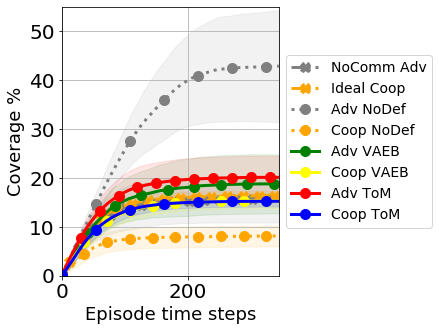

In [67]:
m2_adv_def = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/belief/eval_adv-2d1d6-007500_trustscoring5.pkl"
m2_no_def_baseline = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/r/eval_adv-2d1d6-007500-nodef.pkl"
m2_vae_baseline = "../TheoryOfMind/adversarial_comms-master/adversarial_comms/vaeb/vae_out/eval_adv-2d1d6-007500_vae.pkl"
#m2_adv_def
outfile = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/gaussian/out_2.pdf"
plot3(datalist=[['NoDef',m2_no_def_baseline,'grey','orange',':',True],['VAEB',m2_vae_baseline,'green','yellow','-',False],['ToM',m2_adv_def,'red','blue','-',False]],out_file=outfile)

In [12]:
world_shape = pd.read_pickle(m2_adv_def).attrs['env_config']['world_shape']
max_cov = world_shape[0]*world_shape[1]*pd.read_pickle(m2_adv_def).attrs['env_config']['min_coverable_area_fraction']

In [ ]:
CUDA_LAUNCH_BLOCKING=1 python vaeb_against_faticious2copy.py

In [13]:
adv_def = "../TheoryOfMind/adversarial_comms-master/adversarial_comms/vaeb/vae_out/eval_adv-2d1d6-007500_vae.pkl"

#adv_def = m2_adv_def

drop_cols = ['ts_coop_false_trust_coop','ts_coop_true_trust_adv','comm']

adv_team_idx = [0]
coop_team_idx = np.arange(1,6)

df = pd.read_pickle(adv_def)
df.groupby('agent').sum()

adv_r_sum = 0 
coop_r_sum = 0

for agent_idx in adv_team_idx:
    adv_r_sum+=df[(df.agent==agent_idx) & (df.trial == 0) ].drop(columns=drop_cols)['reward'].sum()
for agent_idx in coop_team_idx:
    coop_r_sum+=df[(df.agent==agent_idx) & (df.trial == 0) ].drop(columns=drop_cols)['reward'].sum()
    
print(adv_r_sum/max_cov)
print(coop_r_sum/max_cov)
# df[df.std_scalar==1.0].groupby(['agent','trial']).sum().drop(columns=['step','ts_coop_false_trust_coop','ts_coop_true_trust_adv','std_scalar','comm'])#.sum()

0.29803240740740744
0.6597222222222223


In [14]:
agg_df = df.groupby(['scaler','agent','trial']).sum()[['reward']].groupby(['scaler','agent']).mean().reset_index()

KeyError: 'scaler'

In [15]:
agg_def = agg_df.sort_values(['agent','scaler'])

NameError: name 'agg_df' is not defined

In [16]:
plt.rcParams.update({'font.size': 18})

# Performances after Readaption Training

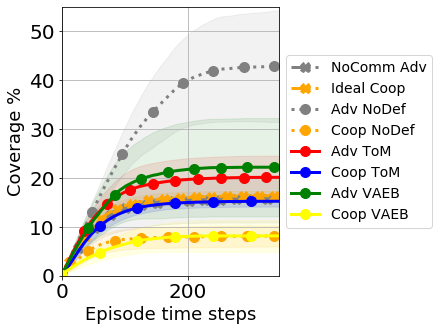

In [154]:
m2_adv_def = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/belief/eval_adv-2d1d6-007500_trustscoring6.pkl"
m2_no_def_baseline = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/r/eval_adv-2d1d6-007500-nodef.pkl"
m2_vae_baseline = "../TheoryOfMind/adversarial_comms-master/adversarial_comms/vaeb/vae_out/eval_adv-7cc4c-011240_vae_faticious_readapt.pkl"
#m2_adv_def
outfile = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/gaussian/out_readapt.pdf"
plot3(datalist=[['NoDef',m2_no_def_baseline,'grey','orange',':',True],['ToM',m2_adv_def,'red','blue','-',False],['VAEB',m2_vae_baseline,'green','yellow','-',False]],out_file=outfile)

In [18]:
def fn_agent(agent_id,data):
    fig_overview = plt.figure(figsize=[7, 4])
    ax = fig_overview.subplots(1, 1)
    markers = ['X','x','.','*','d','D','1',"o",'X','x','.','*','d','D','1',"o"]
    for l,d in data:

        df = pd.read_pickle(d)
        if l == 'ToM':
            for num in range(1,4):
                agg_df3 = df[df.agent==num]
                test = np.array([np.array(i) for i in agg_df3['ts_coop_true_trust_adv'].values])
                agg_df3['ts_coop_true_trust_adv'] = test[:,agent_id-1]
                #print(max(agg_df3['ts_coop_true_trust_adv'].values))
                agg_df3 = agg_df3.groupby(['agent','step']).mean()[['ts_coop_true_trust_adv']].reset_index()


                new_df = agg_df3


                    #ax.plot(new_df[new_df.scaler == std]['ts_coop_true_trust_adv'],'.-',label="scaler {}".format(std),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
                ax.plot(np.arange(0,345),new_df['ts_coop_true_trust_adv'],linestyle='-',label=l + " Agent {}".format(num),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
            continue
        
        if l == 'VAEB':
            for num in range(1,4):
                agg_df3 = df[df.agent==num]
                test = np.array([np.array(i) for i in agg_df3['ts_coop_true_trust_adv'].values])
                agg_df3['ts_coop_true_trust_adv'] = test[:,agent_id-1]
                agg_df3 = agg_df3.groupby(['agent','step']).mean()[['ts_coop_true_trust_adv']].reset_index()


                new_df = agg_df3


                    #ax.plot(new_df[new_df.scaler == std]['ts_coop_true_trust_adv'],'.-',label="scaler {}".format(std),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
                ax.plot(np.arange(0,345),new_df['ts_coop_true_trust_adv'],linestyle='-',label=l + " Agent {}".format(num),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
            continue

            
    ax.set_xlabel("Step")
    ax.set_ylabel("Mean Count")
    ax.grid()

    ax.set_rasterized(True)
    #ax.set_title("Mean False Negative Count")

    leg = ax.legend(fontsize=14,bbox_to_anchor=(1.0, 1.0))
    for line in leg.get_lines():
        line.set_linewidth(3)
    #ax.legend(bbox_to_anchor=(1.0, 1.0))
    fig_overview.tight_layout()
    out_file = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/gaussian/mean_fnc_readapt.pdf"
    #fig_overview.savefig(out_file, format='pdf',dpi=300)
    plt.show()

<ipython-input-18-0d62ecd6991a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df3['ts_coop_true_trust_adv'] = test[:,agent_id-1]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
<ipython-input-18-0d62ecd6991a>:28: SettingWithCopyWarning: 
A value is trying t

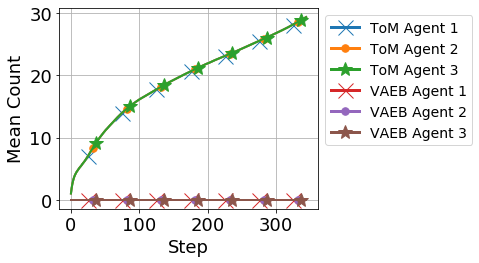

In [19]:
fn_agent(1,[['ToM',m2_adv_def],['VAEB',m2_vae_baseline]])

In [157]:
def get_f1(agent_id,data):
    fig_overview = plt.figure(figsize=[7, 4])
    ax = fig_overview.subplots(1, 1)
    markers = ['X','x','.','*','d','D','1',"o",'X','x','.','*','d','D','1',"o"]
    
    def get_cnt(t='fn',agent_id=1):
        if t == 'fn':
            field ='ts_coop_true_trust_adv'
        elif t == 'tp':
            #field = 'ts_coop_true_trust_coop'
            field = 'ts_coop_false_trust_adv'
        elif t == 'fp':
            field = 'ts_coop_false_trust_coop'

        agg_df3 = df[df.agent==agent_id]
        test = np.array([np.array(i) for i in agg_df3[field].values])
        agg_df3[field] = test[:,agent_id-1]
        agg_df3 = agg_df3.groupby(['agent','step']).mean()[[field]].reset_index()[field]
        return agg_df3
        
    for l,d in data:
        df = pd.read_pickle(d)
        if l == 'ToM':
            for num in range(1,4):
                tp = get_cnt('tp',num)
                fn = get_cnt('fn',num)
                fp = get_cnt('fp',num)

                f1 = (tp /(tp + 0.5*(fp + fn)))

                ax.plot(np.arange(0,345),f1,'.-',label=l+" Agent {}".format(num),linewidth=3,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
            continue
        if l == 'VAEB':
            for num in range(1,4):
                tp = get_cnt('tp',num)
                fn = get_cnt('fn',num)
                fp = get_cnt('fp',num)

                f1 = (tp /(tp + 0.5*(fp + fn)))

                ax.plot(np.arange(0,345),f1,'.-',label=l+" Agent {}".format(num),linewidth=3,markersize=15,marker=markers[0],markevery=(int(50/(num+1))*num,50))
   

    ax.set_xlabel("Step")
    ax.set_ylabel("Mean F1 Score")
    ax.grid()

    ax.set_rasterized(True)

    leg = ax.legend(fontsize=14,bbox_to_anchor=(1.0, 1.0))
    for line in leg.get_lines():
        line.set_linewidth(3)
    #ax.legend(bbox_to_anchor=(1.0, 1.0))
    fig_overview.tight_layout()
    out_file = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/gaussian/mean_f1_readapt.pdf"
    fig_overview.savefig(out_file, format='pdf',dpi=300)
    plt.show()

<ipython-input-157-7438bbdeaea4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df3[field] = test[:,agent_id-1]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
<ipython-input-157-7438bbdeaea4>:17: SettingWithCopyWarning: 
A value is trying to be set on a cop

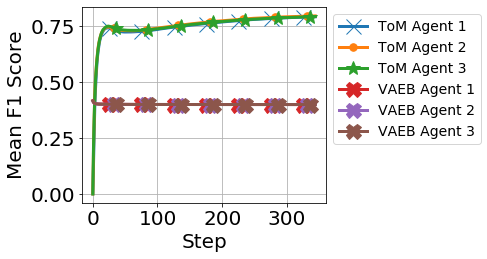

In [158]:
get_f1(1,[['ToM',m2_adv_def],['VAEB',m2_vae_baseline]])

In [30]:
def fp_agent(agent_id,data):
    fig_overview = plt.figure(figsize=[7, 4])
    ax = fig_overview.subplots(1, 1)
    
    num=1
    
    for l,d in data:

        df = pd.read_pickle(d)
        if l == 'ToM':
            for num in range(1,4):
                agg_df3 = df[df.agent==agent_id]
                test = np.array([np.array(i) for i in agg_df3['ts_coop_false_trust_coop'].values])

                agg_df3['ts_coop_false_trust_coop'] = test[:,agent_id-1]


                agg_df3 = agg_df3.groupby(['agent','step']).mean()[['ts_coop_false_trust_coop']].reset_index()
                new_df = agg_df3
                markers = ['X','x','.','*','d','D','1',"o",'X','x','.','*','d','D','1',"o"]

                ax.plot(np.arange(0,345),new_df['ts_coop_false_trust_coop'],'.-',label=l+" Agent {}".format(num),linewidth=3,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
            continue

                
        if l == 'VAEB':
            for num in range(1,4):
                agg_df3 = df[df.agent==num]
                test = np.array([np.array(i) for i in agg_df3['ts_coop_false_trust_coop'].values])

                agg_df3['ts_coop_false_trust_coop'] = test[:,agent_id-1]

                #print(agg_df3['ts_coop_false_trust_coop'])
                agg_df3 = agg_df3.groupby(['agent','step']).mean()[['ts_coop_false_trust_coop']].reset_index()
                new_df = agg_df3
                new_df['ts_coop_false_trust_coop'] = new_df['ts_coop_false_trust_coop'] * (0.33)
                #print(new_df)
                markers = ['X','x','.','*','d','D','1',"o",'X','x','.','*','d','D','1',"o"]

                ax.plot(np.arange(0,345),new_df['ts_coop_false_trust_coop'],'.-',label=l+" Agent {}".format(num),linewidth=3,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))


    ax.set_xlabel("Step")
    ax.set_ylabel("Mean Count")
    ax.grid()
    
    #ax.set_title("Mean False Positive Count")

    ax.set_rasterized(True)

    leg = ax.legend(fontsize=14,bbox_to_anchor=(1.0, 1.0))
    for line in leg.get_lines():
        line.set_linewidth(3)
    #ax.legend(bbox_to_anchor=(1.0, 1.0))
    fig_overview.tight_layout()
    out_file = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/gaussian/mean_fpc_readapt.pdf"
    fig_overview.savefig(out_file, format='pdf',dpi=300)
    plt.show()

<ipython-input-30-1c8ac6d8a51d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df3['ts_coop_false_trust_coop'] = test[:,agent_id-1]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
<ipython-input-30-1c8ac6d8a51d>:31: SettingWithCopyWarning: 
A value is trying

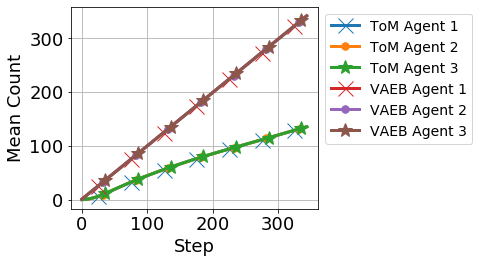

In [31]:
fp_agent(1,[['ToM',m2_adv_def],['VAEB',m2_vae_baseline]])

In [161]:
def tp_agent(agent_id,data):
    fig_overview = plt.figure(figsize=[7, 4])
    ax = fig_overview.subplots(1, 1)
    for l,d in data:

        df = pd.read_pickle(d)
        
        if l == 'ToM':
            for num in range(1,4):
                agg_df3 = df[df.agent==agent_id]
                test = np.array([np.array(i) for i in agg_df3['ts_coop_true_trust_coop'].values])
                agg_df3['ts_coop_true_trust_coop'] = test[:,agent_id-1]
                #print(max(agg_df3['ts_coop_true_trust_adv'].values))
                agg_df3 = agg_df3.groupby(['agent','step']).mean()[['ts_coop_true_trust_coop']].reset_index()


                new_df = agg_df3


                markers = ['X','x','.','*','d','D','1',"o",'X','x','.','*','d','D','1',"o"]

                    #ax.plot(new_df[new_df.scaler == std]['ts_coop_true_trust_adv'],'.-',label="scaler {}".format(std),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
                ax.plot(np.arange(0,345),new_df['ts_coop_true_trust_coop'],linestyle='-',label=l+" Agent {}".format(num),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
            continue
            
        if l == 'VAEB':
            for num in range(1,4):
                agg_df3 = df[df.agent==num]
                test = np.array([np.array(i) for i in agg_df3['ts_coop_true_trust_coop'].values])
                agg_df3['ts_coop_true_trust_coop'] = test[:,agent_id-1]
                #print(max(agg_df3['ts_coop_true_trust_adv'].values))
                agg_df3 = agg_df3.groupby(['agent','step']).mean()[['ts_coop_true_trust_coop']].reset_index()


                new_df = agg_df3
                #num=1


                markers = ['X','x','.','*','d','D','1',"o",'X','x','.','*','d','D','1',"o"]

                    #ax.plot(new_df[new_df.scaler == std]['ts_coop_true_trust_adv'],'.-',label="scaler {}".format(std),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
                ax.plot(np.arange(0,345),new_df['ts_coop_true_trust_coop'],linestyle='-',label=l+" Agent {}".format(num),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
    
    ax.set_xlabel("Step")
    ax.set_ylabel("Mean Count")
    ax.grid()

    ax.set_rasterized(True)
    #ax.set_title("Mean True Positive Cooperative Detection Count")

    leg = ax.legend(fontsize=14,bbox_to_anchor=(1.0, 1.0))
    for line in leg.get_lines():
        line.set_linewidth(3)
    #ax.legend(bbox_to_anchor=(1.0, 1.0))
    fig_overview.tight_layout()
    out_file = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/gaussian/mean_tpc_readapt.pdf"
    fig_overview.savefig(out_file, format='pdf',dpi=300)
    plt.show()

<ipython-input-161-1136dcbc1f6f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df3['ts_coop_true_trust_coop'] = test[:,agent_id-1]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
<ipython-input-161-1136dcbc1f6f>:30: SettingWithCopyWarning: 
A value is tryin

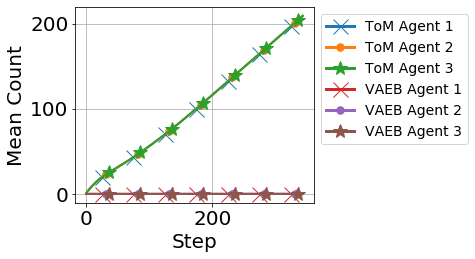

In [162]:
tp_agent(2,[['ToM',m2_adv_def],['VAEB',m2_vae_baseline]])

In [163]:
def tp_adv_agent(agent_id,data):
    fig_overview = plt.figure(figsize=[7, 4])
    ax = fig_overview.subplots(1, 1)
    for l,d in data:

        df = pd.read_pickle(d)
        
        if l == 'ToM':
            for num in range(1,4):
                agg_df3 = df[df.agent==agent_id]
                test = np.array([np.array(i) for i in agg_df3['ts_coop_false_trust_adv'].values])
                agg_df3['ts_coop_false_trust_adv'] = test[:,agent_id-1]
                #print(max(agg_df3['ts_coop_true_trust_adv'].values))
                agg_df3 = agg_df3.groupby(['agent','step']).mean()[['ts_coop_false_trust_adv']].reset_index()


                new_df = agg_df3


                markers = ['X','x','.','*','d','D','1',"o",'X','x','.','*','d','D','1',"o"]

                    #ax.plot(new_df[new_df.scaler == std]['ts_coop_true_trust_adv'],'.-',label="scaler {}".format(std),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
                ax.plot(np.arange(0,345),new_df['ts_coop_false_trust_adv'],linestyle='-',label=l + " Agent {}".format(num),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
            continue
        
        if l == 'VAEB':
            for num in range(1,4):
                agg_df3 = df[df.agent==num]
                test = np.array([np.array(i) for i in agg_df3['ts_coop_false_trust_adv'].values])
                agg_df3['ts_coop_false_trust_adv'] = test[:,agent_id-1]
                #print(max(agg_df3['ts_coop_true_trust_adv'].values))
                agg_df3 = agg_df3.groupby(['agent','step']).mean()[['ts_coop_false_trust_adv']].reset_index()


                new_df = agg_df3


                markers = ['X','x','.','*','d','D','1',"o",'X','x','.','*','d','D','1',"o"]

                    #ax.plot(new_df[new_df.scaler == std]['ts_coop_true_trust_adv'],'.-',label="scaler {}".format(std),linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
                ax.plot(np.arange(0,345),new_df['ts_coop_false_trust_adv'],linestyle='-',label=l+ " Agent {}".format(num) ,linewidth=2,markersize=15,marker=markers[num],markevery=(int(50/(num+1))*num,50))
          
    ax.set_xlabel("Step")
    ax.set_ylabel("Mean Count")
    ax.grid()

    ax.set_rasterized(True)
    #ax.set_title("Mean True Positive Adversary Detection Count")

    leg = ax.legend(fontsize=14,bbox_to_anchor=(1.0, 1.0))
    for line in leg.get_lines():
        line.set_linewidth(3)
    #ax.legend(bbox_to_anchor=(1.0, 1.0))
    fig_overview.tight_layout()
    out_file = "../ray_results/MultiPPO_2021-10-11_10-54-46/MultiPPO_coverage_2d1d6_00000/gaussian/mean_tpc_adv_readapt.pdf"
    fig_overview.savefig(out_file, format='pdf',dpi=300)
    plt.show()

<ipython-input-163-f37e60d002b5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df3['ts_coop_false_trust_adv'] = test[:,agent_id-1]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
<ipython-input-163-f37e60d002b5>:30: SettingWithCopyWarning: 
A value is tryin

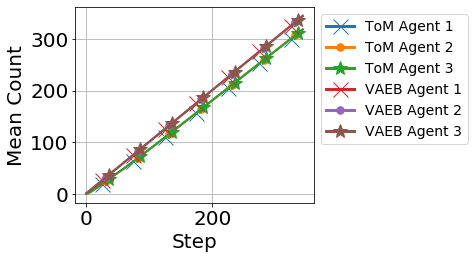

In [164]:
tp_adv_agent(2,[['ToM',m2_adv_def],['VAEB',m2_vae_baseline]])